In [1]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import pancancer_evaluation.config as cfg
import pancancer_evaluation.utilities.analysis_utilities as au

In [2]:
results_dir = os.path.join(cfg.repo_root,
                           'cross_cancer_flip_labels',
                           'cross_cancer_flip_labels')
flip_labels_df = (
    au.load_flip_labels_results(results_dir, 'flip_labels')
      .sort_values(by=['train_identifier', 'test_identifier',
                       'percent_flip', 'signal'])
)
print(flip_labels_df.shape)
flip_labels_df.head(n=10)

(1050, 9)


,auroc,aupr,train_identifier,test_identifier,signal,seed,data_type,percent_flip,experiment
0,0.93951,0.592760,BRAF_COAD,BRAF_COAD,shuffled,42,train,0.1,flip_labels
1,0.33741,0.007788,BRAF_COAD,BRAF_COAD,shuffled,42,test,0.1,flip_labels
2,0.47181,0.073147,BRAF_COAD,BRAF_COAD,shuffled,42,cv,0.1,flip_labels
0,0.99362,0.924860,BRAF_COAD,BRAF_COAD,signal,42,train,0.1,flip_labels
1,0.93182,0.077713,BRAF_COAD,BRAF_COAD,signal,42,test,0.1,flip_labels
2,0.67531,0.146030,BRAF_COAD,BRAF_COAD,signal,42,cv,0.1,flip_labels
0,1.00000,1.000000,BRAF_COAD,BRAF_COAD,shuffled,42,train,0.2,flip_labels
1,0.50616,0.019433,BRAF_COAD,BRAF_COAD,shuffled,42,test,0.2,flip_labels
2,0.44256,0.059475,BRAF_COAD,BRAF_COAD,shuffled,42,cv,0.2,flip_labels
0,1.00000,1.000000,BRAF_COAD,BRAF_COAD,signal,42,train,0.2,flip_labels


In [16]:
percent_flip = 0.2
heatmap_df = au.normalize_to_control(flip_labels_df,
                                     train_id='train_identifier',
                                     test_id='test_identifier',
                                     additional_cols=['percent_flip'])
heatmap_df = (
    heatmap_df.query('percent_flip == @percent_flip')
              .assign(gene=lambda x: x.train_identifier.str.split('_', expand=True)[0],
                      cancer_type=lambda x: x.train_identifier.str.split('_', expand=True)[1])
              .drop(columns=['train_identifier', 'test_identifier'])
              .reset_index()
              .pivot(index='gene', columns='cancer_type', values='aupr')
)
heatmap_df.iloc[:5, :5]

cancer_type,BLCA,BRCA,CESC,COAD,ESCA
gene,,,,,
BRAF,NaN,NaN,NaN,0.007246,NaN
EGFR,NaN,NaN,NaN,NaN,NaN
KRAS,NaN,NaN,NaN,0.010453,NaN
PTEN,NaN,0.009635,-0.003936,-0.002991,NaN
TP53,0.045964,0.056120,0.015210,0.031790,0.013568


Text(0.5, 1.0, 'Percent of labels flipped: 0.2')

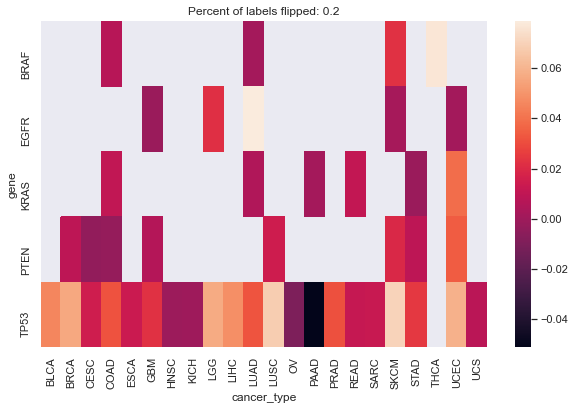

In [22]:
sns.set({'figure.figsize': (10, 6)})
sns.heatmap(heatmap_df)
plt.title('Percent of labels flipped: {}'.format(percent_flip))